In [1]:
from IPython.display import DisplayObject

class Audio(DisplayObject):
    _read_flags = 'rb'
    
    def __init__(self, data=None, filename=None, url=None, embed=None, rate=None, autoplay=False, maxvalue=None):
        if filename is None and url is None and data is None:
            raise ValueError("No image data found. Expecting filename, url, or data.")
        if embed is False and url is None:
            raise ValueError("No url found. Expecting url when embed=False")

        if url is not None and embed is not True:
            self.embed = False
        else:
            self.embed = True
        self.autoplay = autoplay
        self.maxvalue = maxvalue
        super(Audio, self).__init__(data=data, url=url, filename=filename)

        if self.data is not None and not isinstance(self.data, bytes):
            self.data = self._make_wav(data,rate)

    def reload(self):
        """Reload the raw data from file or URL."""
        import mimetypes
        if self.embed:
            super(Audio, self).reload()

        if self.filename is not None:
            self.mimetype = mimetypes.guess_type(self.filename)[0]
        elif self.url is not None:
            self.mimetype = mimetypes.guess_type(self.url)[0]
        else:
            self.mimetype = "audio/wav"

    def _make_wav(self, data, rate):
        """ Transform a numpy array to a PCM bytestring """
        import struct
        from io import BytesIO
        import wave

        try:
            import numpy as np

            data = np.array(data, dtype=float)
            if len(data.shape) == 1:
                nchan = 1
            elif len(data.shape) == 2:
                # In wave files,channels are interleaved. E.g.,
                # "L1R1L2R2..." for stereo. See
                # http://msdn.microsoft.com/en-us/library/windows/hardware/dn653308(v=vs.85).aspx
                # for channel ordering
                nchan = data.shape[0]
                data = data.T.ravel()
            else:
                raise ValueError('Array audio input must be a 1D or 2D array')
            if self.maxvalue is None:
                maxvalue = np.max(np.abs(data))
            else:
                maxvalue = self.maxvalue
            scaled = np.int16(data/maxvalue * 32767).tolist()
        except ImportError:
            # check that it is a "1D" list
            idata = iter(data)  # fails if not an iterable
            try:
                iter(idata.next())
                raise TypeError('Only lists of mono audio are '
                    'supported if numpy is not installed')
            except TypeError:
                # this means it's not a nested list, which is what we want
                pass
            if self.maxvalue is None:
                maxvalue = float(max([abs(x) for x in data]))
            else:
                maxvalue = self.maxvalue
            scaled = [int(x/maxvalue * 32767) for x in data]
            nchan = 1

        fp = BytesIO()
        waveobj = wave.open(fp,mode='wb')
        waveobj.setnchannels(nchan)
        waveobj.setframerate(rate)
        waveobj.setsampwidth(2)
        waveobj.setcomptype('NONE','NONE')
        waveobj.writeframes(b''.join([struct.pack('<h',x) for x in scaled]))
        val = fp.getvalue()
        waveobj.close()
        return val

    def _data_and_metadata(self):
        """shortcut for returning metadata with url information, if defined"""
        md = {}
        if self.url:
            md['url'] = self.url
        if md:
            return self.data, md
        else:
            return self.data

    def _repr_html_(self):
        src = """
                <audio controls="controls" {autoplay}>
                    <source src="{src}" type="{type}" />
                    Your browser does not support the audio element.
                </audio>
              """
        return src.format(src=self.src_attr(),type=self.mimetype, autoplay=self.autoplay_attr())

    def src_attr(self):
        import base64
        if self.embed and (self.data is not None):
            data = base64=base64.b64encode(self.data).decode('ascii')
            return """data:{type};base64,{base64}""".format(type=self.mimetype,
                                                            base64=data)
        elif self.url is not None:
            return self.url
        else:
            return ""

    def autoplay_attr(self):
        if(self.autoplay):
            return 'autoplay="autoplay"'
        else:
            return ''
        
print("This cell defines the Audio class.")

This cell defines the Audio class.


In [2]:
!start refine

/bin/sh: 1: start: not found


In [3]:
import numpy as np
framerate = 44100
t = np.linspace(0,5,framerate*5)
data = np.sin(2*np.pi*440*np.sin(10*t**2))
data= np.sin(2*np.pi*440*t)

In [4]:
import wave
import struct
scaled = np.int16(data/np.max(np.abs(data)) * 32767)
waveobj = wave.open("funky.wav",mode='wb')
waveobj.setnchannels(1)
waveobj.setframerate(framerate)
waveobj.setsampwidth(2)
waveobj.setcomptype('NONE','NONE')
waveobj.writeframes(b''.join([struct.pack('<h',x) for x in scaled]))
waveobj.close()

Audio("funky.wav")

In [5]:
CHANNELS = 1
swidth = 2
Change_RATE = 4

spf = wave.open('funky.wav', 'rb')
RATE=spf.getframerate()
signal = spf.readframes(-1)

wf = wave.open('changed.wav', 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(swidth)
wf.setframerate(RATE*Change_RATE)
wf.writeframes(signal)
wf.close()
Audio("changed.wav")

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
from scipy.signal import chirp, sweep_poly

In [21]:
t = np.linspace(0, 10, 5001)
w = chirp(t, f0=12.5, f1=2.5, t1=10, method='linear')


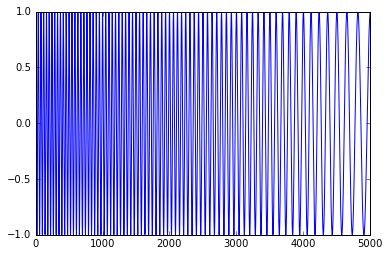

In [22]:
plt.plot(w)

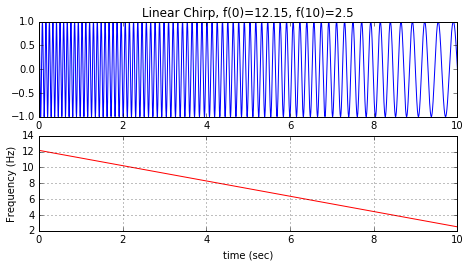

In [23]:
#https://scipy.github.io/old-wiki/pages/Cookbook/FrequencySweptDemo.html

f0=12.15
f1=2.5
t1=10


from pylab import figure, plot, show, xlabel, ylabel, subplot, grid, title, yscale, savefig, clf

FIG_SIZE = (7.5, 3.75)
figure(1, figsize=FIG_SIZE)

t = np.linspace(0, t1, 5001)
w = chirp(t, f0=f0, f1=f1, t1=t1, method='linear')

    
clf()

plt.subplot(2,1,1)
plot(t, w)
tstr = "Linear Chirp, f(0)=%g, f(%g)=%g" % (f0, t1, f1)
title(tstr)

subplot(2,1,2)
plot(t, f0 + (f1-f0)*t/t1, 'r')
grid(True)
ylabel('Frequency (Hz)')
xlabel('time (sec)')

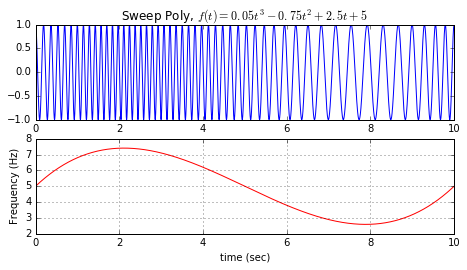

In [24]:
from numpy import poly1d
p = poly1d([0.05, -0.75, 2.5, 5.0])

t = np.linspace(0, t1, 5001)
w = sweep_poly(t, p)
figure(1, figsize=FIG_SIZE)
clf()

subplot(2,1,1)
plot(t, w)
tstr = "Sweep Poly, $f(t) = 0.05t^3 - 0.75t^2 + 2.5t + 5$"
title(tstr)

subplot(2,1,2)
plot(t, p(t), 'r')
grid(True)
ylabel('Frequency (Hz)')
xlabel('time (sec)')

In [28]:
#https://github.com/HelsinkiHacklab/ledmatrix/blob/master/pyaudio_tests/chirp.py
import scipy
from scipy.io.wavfile import write
from scipy.signal import chirp, sweep_poly
sampleRate=44100

chirp_start_hz = 50.0
chirp_end_hz = 12000.0
chirp_time_s = 5.0

xx=np.linspace(0, chirp_time_s, sampleRate)

sampletimes = np.linspace(0.0, chirp_time_s, chirp_time_s*sampleRate)
chirpdata = scipy.signal.chirp(sampletimes, chirp_start_hz, chirp_time_s, chirp_end_hz)
audio_chirp = np.interp(chirpdata, [-1.0, 1.0], [-1*2**15, 2**15-1]).astype(np.int16)

write('test.wav', sampleRate, audio_chirp)
Audio("test.wav")

ValueError: x and y must have same first dimension

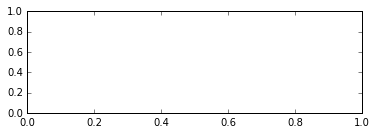

In [30]:
from pylab import figure, plot, show, xlabel, ylabel, subplot, grid, title, yscale, savefig, clf
clf()
#w = chirp(t, f0=f0, f1=f1, t1=t1, method='linear')
plt.subplot(2,1,1)

plot(sampleRate, chirpdata)
#tstr = "Linear Chirp, f(0)=%g, f(%g)=%g" % (f0, t1, f1)
#title(tstr)

subplot(2,1,2)
plot(sampleRate,chirp_start_hz+ (chirp_end_hz-chirp_start_hz)*chirpdata/chirp_time_s, 'r')
grid(True)
ylabel('Frequency (Hz)')
xlabel('time (sec)')

In [31]:
S, freqs, bins, im = plt.specgram(x, NFFT=1024, Fs=fs, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')

NameError: name 'x' is not defined

In [ ]:
!pip install chirp
#deprecated?